In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fftshift
from scipy.io import wavfile

In [4]:
from dsp.fir import WSFilter

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def read_real(filepath, dtype):
    with open(filepath, 'rb') as input_file:
        data = np.fromfile(input_file, dtype=dtype)
    return data
    
def read_iq(filepath, dtype):
    data = read_real(filepath, dtype)
    data = np.reshape(data, (-1, 2))
    iq_samples = data[:, 0] + 1j * data[:, 1]
    return iq_samples
    
iq_samples = read_iq('../sdr/data/iq_speech', np.int16)

In [7]:
iq_samples.shape

(12001280,)

In [8]:
std_fsize = (20, 10)

def welch(samples, sample_rate, nper=1024):
    f, Pxx = signal.welch(samples, sample_rate, nperseg=nper, detrend=lambda x: x)
    f, Pxx = fftshift(f), fftshift(Pxx)
    ind = np.argsort(f)
    f, Pxx = np.take_along_axis(f, ind, axis=0), np.take_along_axis(Pxx, ind, axis=0)
    
    plt.figure(figsize=std_fsize)
    plt.semilogy(f/1e3, Pxx)
    plt.xlabel('f [kHz]')
    plt.ylabel('PSD [Power/Hz]')
    plt.grid()

    plt.xticks(np.linspace(-sample_rate/2e3, sample_rate/2e3, 31))
    plt.xlim(-sample_rate/2e3, sample_rate/2e3)

### IQ samples spectral density

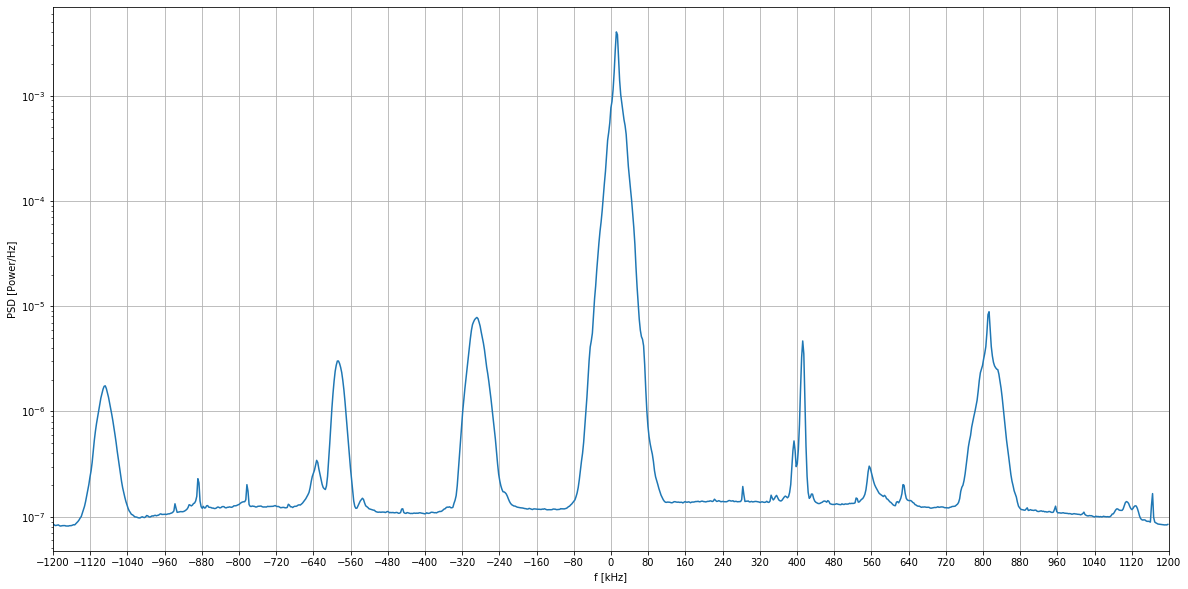

In [9]:
sample_rate = 2400000
welch(iq_samples, sample_rate)

### Now let's compare the effects of offline and online filtering (windowed-sinc).

In [10]:
sample_rate_fm = 240000
M = sample_rate // sample_rate_fm
ws_filter = WSFilter(512, M, 1 / (2 * 1.2 * M))

In [11]:
import time

start = time.time()
filtered_offline = ws_filter.complex_run(iq_samples)
print(time.time() - start)

0.8923161029815674


In [12]:
filtered_offline.shape

(1200076,)

In [13]:
(iq_samples.shape[0] - 512 + 1) // 10  # tyle powinno być!

1200076

In [14]:
iq_samples.shape

(12001280,)

In [15]:
filtered_offline.shape

(1200076,)

In [16]:
filtered_offline[:10]

array([0.37192599+0.42674503j, 0.40410936+0.30773262j,
       0.35481903+0.67538466j, 0.23021014+0.9617174j ,
       0.36851481+0.53009026j, 0.40859819+0.13732839j,
       0.37449966+0.32790752j, 0.33769733+0.35244048j,
       0.28860341+0.36818044j, 0.10521529+0.68660432j])

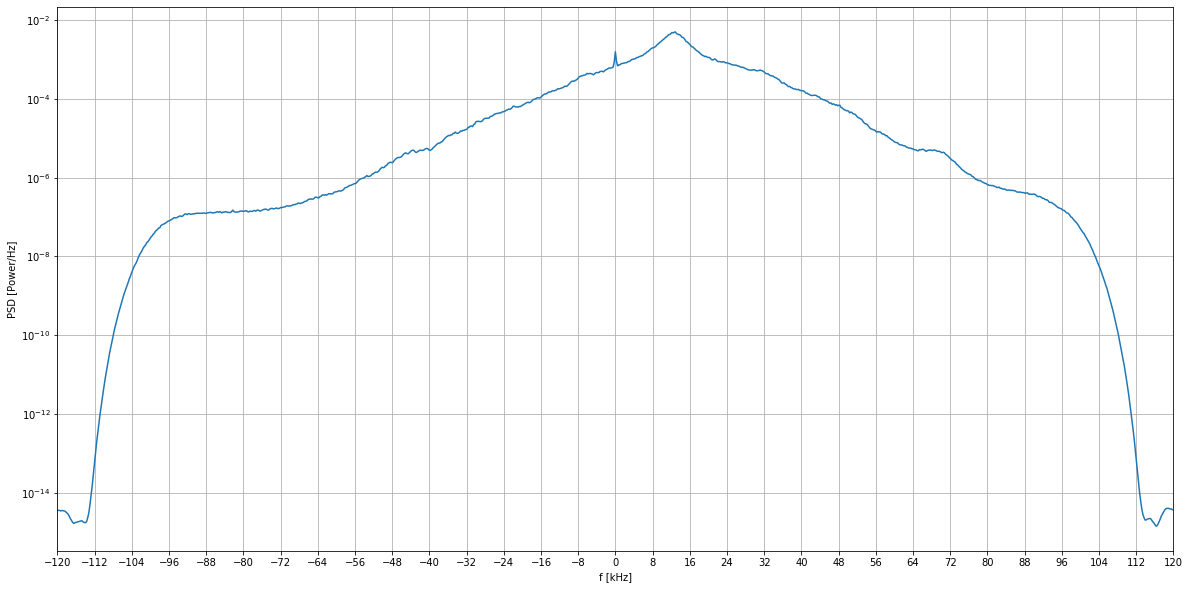

In [17]:
welch(filtered_offline, sample_rate_fm)

In [18]:
r_max = max([abs(c.real) for c in filtered_offline])
scaled_r = [c.real / r_max * 2**15 for c in filtered_offline]
i_max = max([abs(c.imag) for c in filtered_offline])
scaled_i = [c.imag / i_max * 2**15 for c in filtered_offline]
filtered_better = np.array([np.int16(r) + 1j * np.int16(i) for r, i in zip(scaled_r, scaled_i)], dtype=np.complex128)

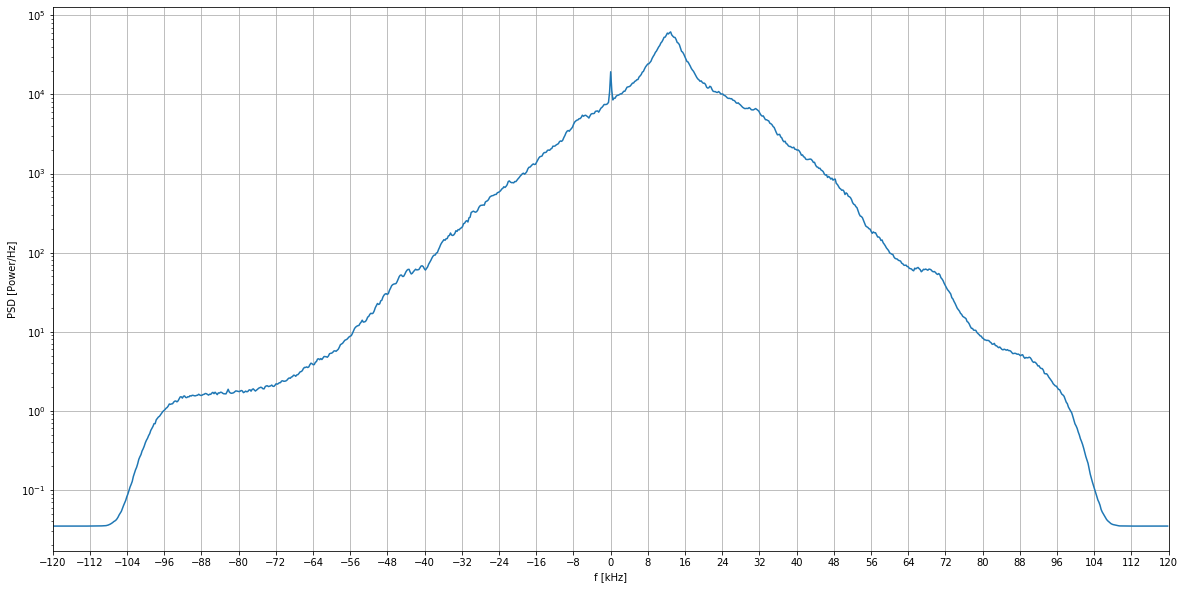

In [19]:
welch(filtered_better, sample_rate_fm)

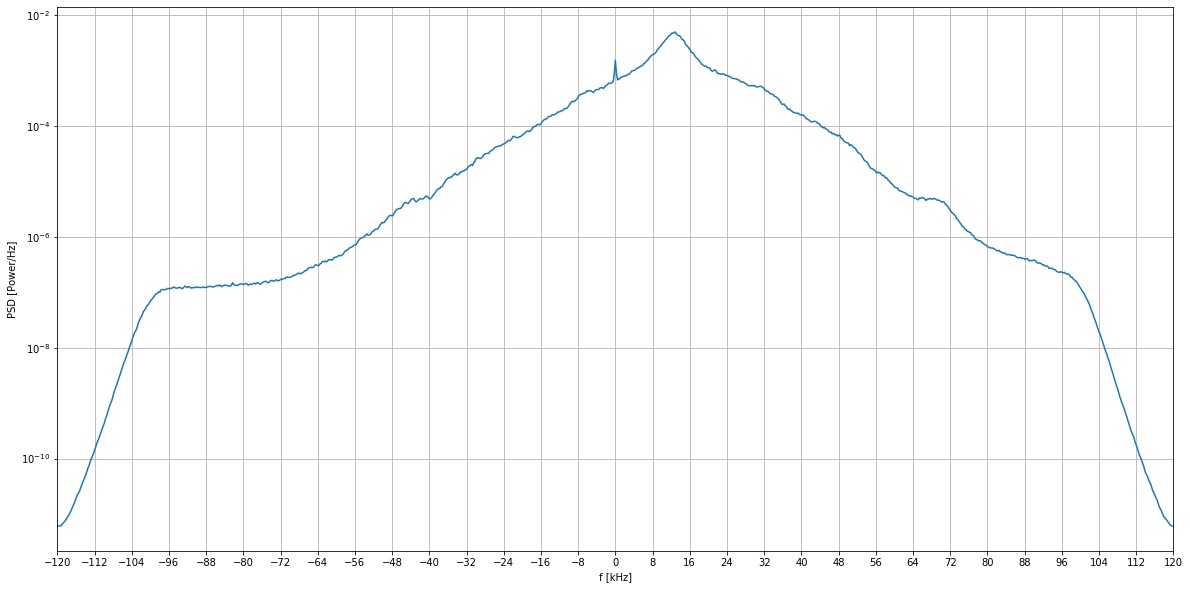

In [22]:
welch(signal.decimate(iq_samples, 10), sample_rate_fm)

In [23]:
from math import cos, sin, pi as PI


def demodulate(samples):
    dm_samples = np.empty(shape=(len(samples) - 1, ))
    
    for i in range(len(dm_samples)):
        angle_c = np.arctan2(samples[i + 1].real, samples[i + 1].imag)
        angle_p = np.arctan2(samples[i].real, samples[i].imag)
        angle_diff = angle_c - angle_p
        
        if (angle_diff > PI):
            angle_diff = 2 * PI - angle_diff
        elif (angle_diff < -PI):
            angle_diff = -2 * PI - angle_diff
        dm_samples[i] = angle_diff
    
    return dm_samples

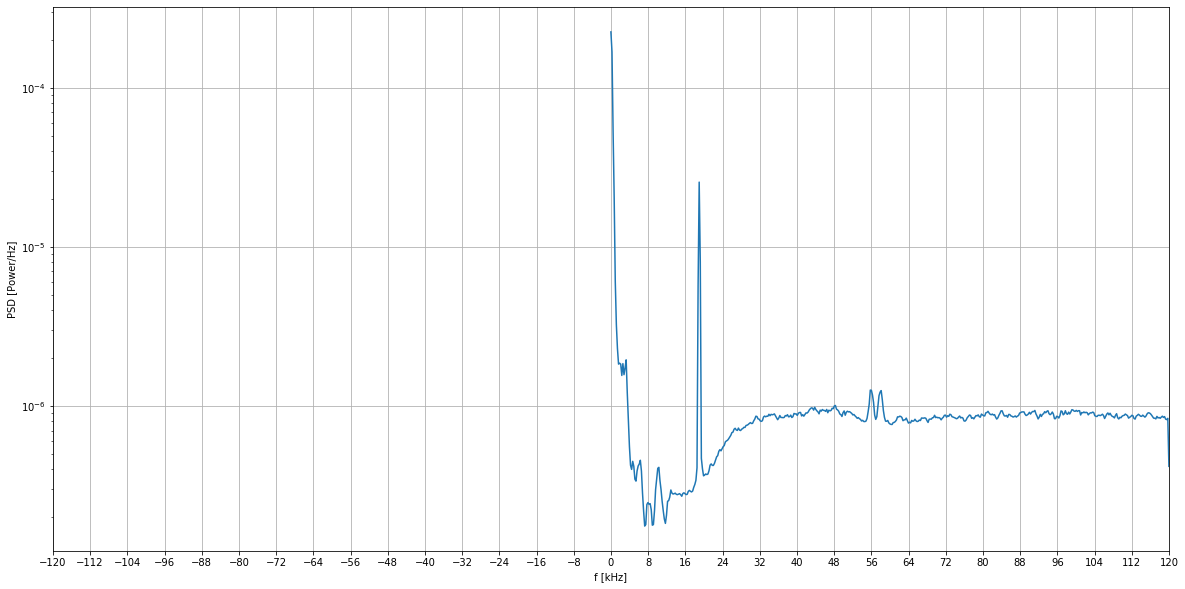

In [26]:
demod = demodulate(filtered_offline)
welch(demod, sample_rate_fm)

In [27]:
iq_du = read_real('../sdr/data/iq_sru', np.int16)

In [28]:
iq_du.shape[0]

1200116

In [29]:
demod.shape[0] 

1200075

In [32]:
audio_rate = 48000
audio = signal.decimate(demod, sample_rate_fm // audio_rate)
wavfile.write("./audio/speech_messedup.wav", rate=audio_rate, data=audio)

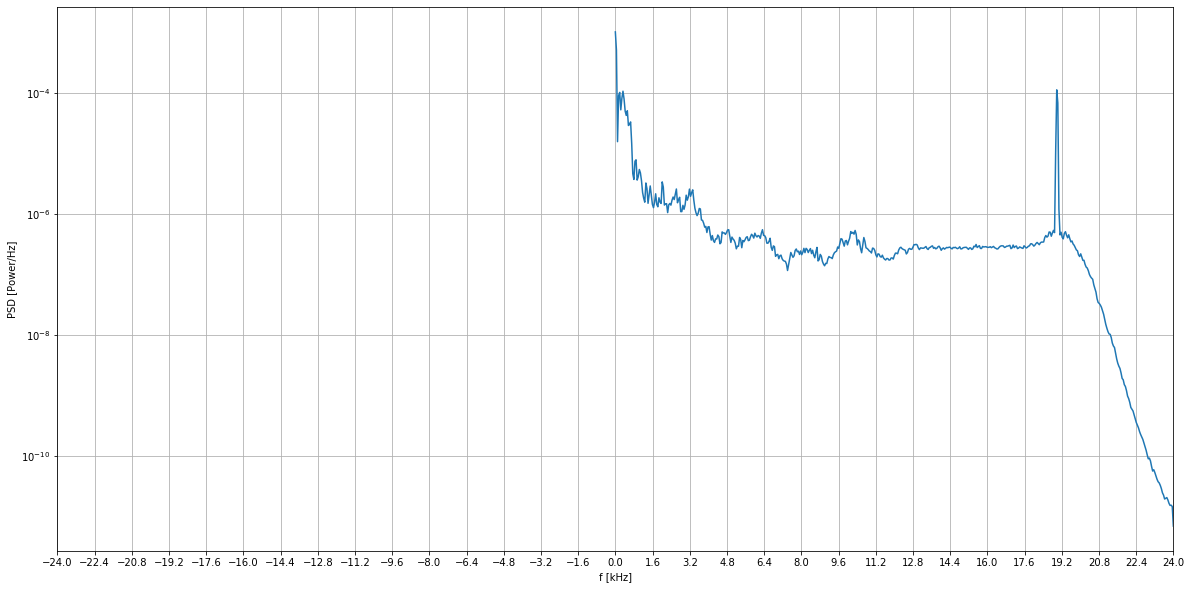

In [33]:
welch(audio, audio_rate)

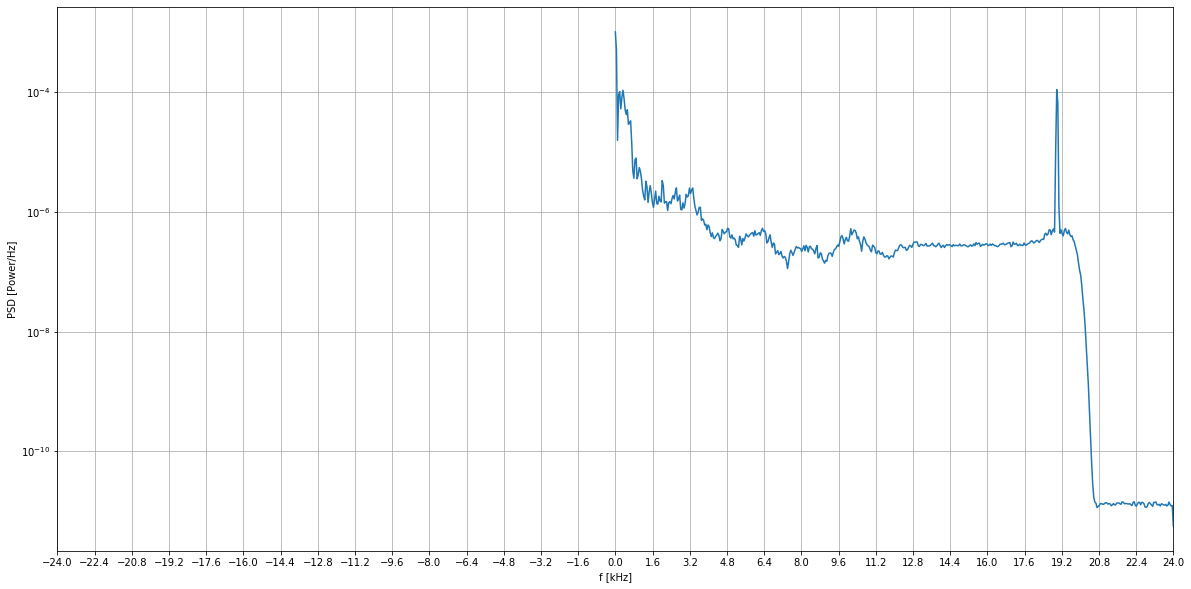

In [34]:
c_audio = read_real('../sdr/data/iq_speech_final_float', np.float64)
welch(c_audio, audio_rate)

In [35]:
final_audio = np.int16(c_audio / PI * 2**15)
wavfile.write("./audio/c_speech.wav", rate=audio_rate, data=final_audio)

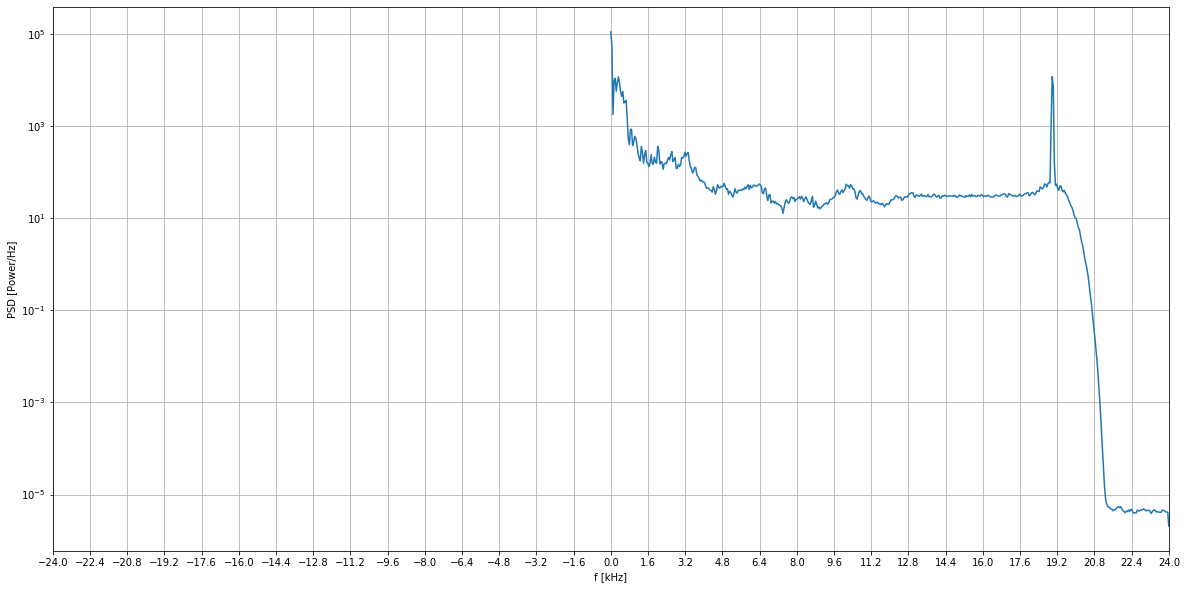

In [36]:
c_audio_int = read_real('../sdr/data/iq_speech_final_fixed', np.int16)
welch(c_audio_int, audio_rate)